<a href="https://colab.research.google.com/github/Papa-Panda/random_thoughts/blob/main/foreground_mask_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# test reading a file, successful
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
# df0=pd.read_csv('drive/My Drive/nimbus/Data_tabs_by_date.csv')

Mounted at /content/drive


In [ ]:
from IPython.display import display
from PIL import Image


In [ ]:
# test opening a image file, successful
path_to_image_1 = 'drive/My Drive/foreground_prediction/fg/img84.jpg'
path_to_image_1 = 'drive/My Drive/foreground_prediction/fg/mask84.jpg'


img = Image.open(path_to_image_1)

# Display basic information about the image
print("Image Format:", img.format)
print("Image Mode:", img.mode)
print("Image Size:", img.size)
# display(img)

Image Format: JPEG
Image Mode: L
Image Size: (790, 687)


In [ ]:
from torchvision.transforms import Resize, ToPILImage

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.nn.functional import relu


In [ ]:

# # class UNet(nn.Module):
# #     def __init__(self):
# #         super(UNet, self).__init__()

# #         # Down-sampling path
# #         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
# #         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

# #         # Up-sampling path
# #         self.upconv1 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)

# #     def forward(self, x):
# #         # Down-sampling
# #         x = F.relu(self.conv1(x))
# #         x_down = self.maxpool(x)

# #         # Up-sampling
# #         x_up = self.upconv1(x_down)

# #         return x_up


# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()

#         # Down-sampling path
#         self.down_conv1 = self.conv_block(3, 64)
#         self.down_conv2 = self.conv_block(64, 128)
#         self.down_conv3 = self.conv_block(128, 256)
#         self.down_conv4 = self.conv_block(256, 512)

#         # Up-sampling path
#         self.up_conv4 = self.conv_block(512, 256)
#         self.up_conv3 = self.conv_block(256, 128)
#         self.up_conv2 = self.conv_block(128, 64)

#         # Final convolution
#         self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         # Down-sampling
#         down1 = self.down_conv1(x)
#         down1_pool = F.max_pool2d(down1, kernel_size=2, stride=2)
#         down2 = self.down_conv2(down1_pool)
#         down2_pool = F.max_pool2d(down2, kernel_size=2, stride=2)
#         down3 = self.down_conv3(down2_pool)
#         down3_pool = F.max_pool2d(down3, kernel_size=2, stride=2)
#         down4 = self.down_conv4(down3_pool)
#         down4_pool = F.max_pool2d(down4, kernel_size=2, stride=2)

#         # Up-sampling
#         up4 = F.interpolate(down4_pool, scale_factor=2, mode='bilinear', align_corners=True)
#         print('down4', down4.shape)
#         print('up4', up4.shape)
#         up4 = torch.cat([down4, up4], dim=1)
#         up4 = self.up_conv4(up4)
#         up3 = F.interpolate(up4, scale_factor=2, mode='bilinear', align_corners=True)
#         up3 = torch.cat([down2, up3], dim=1)
#         up3 = self.up_conv3(up3)
#         up2 = F.interpolate(up3, scale_factor=2, mode='bilinear', align_corners=True)
#         up2 = torch.cat([down1, up2], dim=1)
#         up2 = self.up_conv2(up2)

#         # Final convolution
#         output = self.final_conv(up2)
#         output = torch.sigmoid(output)  # Apply sigmoid activation for binary classification

#         return output



class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        # xu3 = self.upconv3(xe22)
        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out



In [ ]:
class CustomDataset(Dataset):
    # def __init__(self, image_paths, mask_paths, transform=None, target_size=(64, 64)):
    def __init__(self, image_paths, mask_paths, transform=None, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        # Resize images and masks to the target size
        image = Resize(self.target_size)(image)
        mask = Resize(self.target_size, interpolation=Image.NEAREST)(mask)
        # display(image)
        # display(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        smooth = 1e-6
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        dice = (2.0 * intersection + smooth) / (union + smooth)
        loss = 1 - dice
        return loss

# Example paths to images and masks
# image_paths = ["path_to_image_1.jpg", "path_to_image_2.jpg", ...]
image_paths = [ 'drive/My Drive/foreground_prediction/fg/img'+str(i)+'.jpg' for i in range(292)]
# mask_paths = ["path_to_mask_1.jpg", "path_to_mask_2.jpg", ...]
mask_paths = [ 'drive/My Drive/foreground_prediction/fg/mask'+str(i)+'.jpg' for i in range(292)]

# Create custom dataset
dataset = CustomDataset(image_paths, mask_paths, transform=ToTensor())

# Define data loader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet()
# criterion = nn.BCELoss()
# criterion = DiceLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:

# Train the model
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images = images.to(device)
        masks = masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        # print(outputs)
        # print(masks)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')

Epoch 1/5: 100%|██████████| 73/73 [31:19<00:00, 25.75s/it]


Epoch 1/5, Loss: 0.08609585433381878


Epoch 2/5: 100%|██████████| 73/73 [28:07<00:00, 23.12s/it]


Epoch 2/5, Loss: 0.05109035158657456


Epoch 3/5: 100%|██████████| 73/73 [28:11<00:00, 23.18s/it]


Epoch 3/5, Loss: 0.08546629264848689


Epoch 4/5: 100%|██████████| 73/73 [28:10<00:00, 23.16s/it]


Epoch 4/5, Loss: 0.06120305375693596


Epoch 5/5: 100%|██████████| 73/73 [28:16<00:00, 23.24s/it]

Epoch 5/5, Loss: 0.06304001686966991


In [10]:
# image size input are slighlty different
# need to normalize
# first try cutting

In [11]:
# # image_paths = [ 'drive/My Drive/foreground_prediction/fg/img'+str(i)+'.jpg' for i in range(292)]
# # # mask_paths = ["path_to_mask_1.jpg", "path_to_mask_2.jpg", ...]
# # mask_paths = [ 'drive/My Drive/foreground_prediction/fg/mask'+str(i)+'.jpg' for i in range(292)]
# # path_to_image_1 = 'drive/My Drive/foreground_prediction/fg/img84.jpg'

# for i in range(20):

#   img = Image.open(image_paths[i])
#   print("Image Size:", img.size)
#   img = Image.open(mask_paths[i])
#   print("Image Size:", img.size)


In [12]:
# double checked the data by display(image), the image is read well

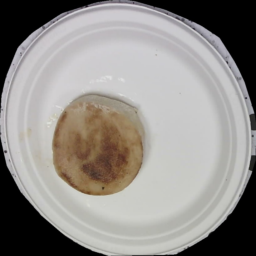

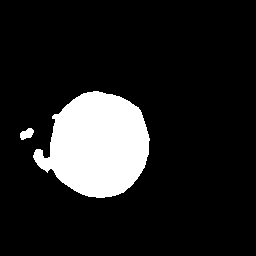

In [21]:
# Load the trained model
model = UNet()
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Define the transform to convert PIL image to tensor
transform = ToTensor()

# Load and preprocess the image
pick_index = 88
image_path = image_paths[pick_index]
image = Image.open(image_path)
# image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image = Resize((256,256))(image)
image_tensor = transform(Resize((256,256))(image)).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Post-process the output
output_binary = (output > 0.5).float()  # Convert probabilities to binary values (0 or 1)

# Convert the tensor back to PIL image
output_image = ToPILImage()(output_binary.squeeze(0))

display(image)
display( output_image )